# Download neural data

This template walks through a simple example of downloading raw time series and spectrogram data, given some time interval of interest. After we obtain the raw time series, we will also locally compute our own spectrogram and compare to the API spectrogram.

We utilize the Rune Stream API and Python package `runeq`. Full API documentation can be found here: https://docs.runelabs.io/. Information about the Python package can be found here: https://runeq.readthedocs.io/en/latest/.

In [1]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from runeq import Config, stream
from scipy import stats
from scipy import signal

## Functions for pulling raw time series and spectrogram data with the API

`get_neural_time_series` and `get_spectrogram` will pull data with the Stream API and save as CSVs. These wrapper functions can be easily modified to access the other API endpoints.

In [2]:
def get_neural_time_series(client, params, save_filepath):
    '''
    Iterates through pages and makes API calls for raw time series data
    Saves as a CSV

    Inputs: client
            API parameters (see API documentation)
            save_filepath, ex. './new_time_series_file'
    Outputs: saved CSV file
    '''

    accessor = client.LFP(**params)

    # loop through pages of API calls and appends to a single dataframe
    df = pd.DataFrame()
    for page in accessor.iter_csv_text():
        page_df = pd.read_csv(io.StringIO(page))
        df = df.append(page_df, ignore_index=True)

    # save dataframe to a csv
    df.to_csv(save_filepath, index=False)
    
    return df

def get_spectrogram(client, params, save_filepath):
    '''
    Makes API calls for spectrogram data
    Saves separate CSV's for every channel

    Inputs: client
            API parameters (see API documentation)
            save_filepath, ex. './new_spectrogram_file'
    Outputs: saved CSV file
    '''

    accessor = client.LFP(expression='spectrogram(lfp)', **params)

    # initialize a dataframe for every channel
    ch_list = params['channels'].split(',')
    df_dict = {ch: pd.DataFrame() for ch in ch_list}

    # loop through pages of API calls and appends to a single dataframe per channel
    for page in accessor.iter_json_data():
        for ch in ch_list:
            page_ch = pd.DataFrame(page['data']['channel.' + ch]).transpose()
            page_ch.columns = page['y']
            page_ch.insert(0, 'time', page['time']['channel.' + ch])
            df_dict[ch] = df_dict[ch].append(page_ch, ignore_index=True)

    # save spectrograms for each channel as separate CSV's
    for key in df_dict.keys():
        df_dict[key].to_csv(save_filepath + '_ch' + key, index=False)
    
    return df_dict

## 1. Initialize API credentials

First initialize your API credentials. These credentials are analogous to having a username/password for accessing patient data. You will set up a 'client' to access data for each patient, and each client has its own ID and secret. 

- Navigate to the web app (https://app.runelabs.io/patients) as an **admin** user
- Click the pencil next to the patient of interest
- Open the 'Clients' section and create a new client. Copy the ID and secret (these will only be shown once)
- Open the 'Devices' section to find the device IDs.

Next, set up a .yaml file with your client ID and secret. This is text file that will store your credentials.  An example can be found here: https://github.com/rune-labs/runeq-python/blob/master/example_config.yaml.

We will load up this .yaml file to set up a client with `runeq`.

In [3]:
# set up a client

cfg = Config('/Users/witney/Documents/api_config/rcs07_config.yaml')
client = stream.V1Client(cfg)

This client object can now be used to make API calls. Next, we will specify the parameters for our API calls. Check out the full API documentation for required vs. optional parameters per endpoint.

## 2. Specify endpoint parameters and retrieve data

In this example, we will obtain data for all 4 channels from the right RC+S device.

In [4]:
params = {
    'device_id': 'NPC700403H',
    'start_time': 1584646104,  # unix time stamp
    'end_time': 1584647285,    # unix time stamp    
    'channels': '0,1,2,3',
    'timestamp': 'unix'
}

If you do not know the unix time stamps, you can convert from date time. For example:
```
datetime.datetime(2020, 1, 1).timestamp()
```

We will pass the client, our parameters, and a file path for saving our data into our functions above to obtain the CSV data. Be sure to change the file directories below. If you do not want to enter the full path every time, you could specify a base path, and then append the file name. For example:

```
import io

# Set BASE_PATH to the folder where related files are stored / will be saved
BASE_PATH = '~/Documents/data_folder'

# expanduser allows us to use ~ as a shortcut for home
FULL_BASE_PATH = os.path.expanduser(BASE_PATH)

# full path to a specific file
os.path.join(FULL_BASE_PATH, 'name_of_data_file')
```

In [5]:
# retrieve neural time series and spectrogram data

time_series = get_neural_time_series(client, params, '/Users/witney/Documents/api_data/nb01_ex01_neural_time_series')
spectro = get_spectrogram(client, params, '/Users/witney/Documents/api_data/nb01_ex01_spectrogram')

## 3. Load CSV's and clean dataframes

The functions above both save the data to CSV's and return the dataframe. If we wanted to directly load the spectrogram and time series as dataframes, we could read them with `pd.read_csv`. Here, we will load the spectrogram for channel 0, but they should be saved for all channels in the specified path with `_ch#` appended to the end of the file name. We will locally compute our own spectrogram and compare to the API output. Be sure to change the file paths below.

In [6]:
time_series = pd.read_csv('/Users/witney/Documents/api_data/nb01_ex01_neural_time_series.csv')
spectro = pd.read_csv('/Users/witney/Documents/api_data/nb01_ex01_spectrogram_ch0.csv')

The `spectro` dataframe is organized with one frequency per column and one time point per row. `timestamp` gives the unix time stamp for the corresponding power values. If converted to date time format, note that UTC time will need to be adjusted to the appropriate time zone. 

In [7]:
spectro

,time,0,1,2,3,4,5,6,7,8,...,115,116,117,118,119,120,121,122,123,124
0,1584646104,6.115595e-13,5.458663e-11,2.658079e-12,1.433219e-12,4.607640e-12,5.706380e-13,1.878613e-12,5.572002e-12,1.412470e-12,...,1.989350e-13,9.817866e-14,3.143601e-13,2.618526e-12,1.857940e-13,4.191465e-12,3.136279e-12,2.914059e-12,2.891142e-13,7.791066e-13
1,1584646105,2.439943e-14,1.697798e-11,7.921616e-12,4.039895e-12,6.249358e-14,3.324127e-13,2.137339e-12,5.524374e-12,9.157283e-12,...,1.882209e-12,1.334179e-13,2.378035e-13,6.996885e-12,3.929694e-14,1.988738e-12,1.212974e-12,4.014006e-13,1.754611e-12,7.839427e-13
2,1584646106,7.054069e-14,5.370560e-12,1.017927e-11,2.607148e-12,1.950424e-12,6.598222e-13,9.528701e-13,4.306778e-14,7.234965e-13,...,5.402693e-13,8.254265e-13,1.915416e-13,6.287883e-13,3.225236e-13,2.718204e-12,2.646861e-12,2.788595e-12,8.499187e-13,6.793180e-13
3,1584646107,1.209511e-12,3.560191e-13,1.561056e-11,1.681320e-11,8.558831e-13,6.401173e-12,1.285776e-11,1.409356e-13,6.952712e-12,...,2.193581e-12,5.283088e-13,7.141674e-13,2.334204e-12,7.307384e-13,3.034357e-12,7.048691e-13,1.602853e-12,1.524561e-12,1.364413e-12
4,1584646108,5.364149e-17,2.532073e-11,2.874898e-12,1.286921e-12,7.763988e-13,2.120151e-12,9.253399e-13,4.478959e-12,4.156628e-12,...,1.846380e-12,8.516004e-13,5.947154e-13,4.745492e-13,2.092711e-12,7.486285e-12,1.973820e-12,5.000703e-14,1.573118e-12,1.930755e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,1584647280,5.427233e-13,4.627316e-12,2.936078e-12,8.505917e-12,7.962112e-12,1.214944e-12,1.250020e-11,6.186214e-12,3.163509e-12,...,1.353057e-13,1.738938e-13,6.762319e-13,6.289009e-13,1.091524e-12,6.739814e-12,7.515532e-13,4.782486e-13,8.590583e-13,6.918207e-13
1177,1584647281,6.302700e-14,5.010097e-11,8.794747e-12,1.163124e-11,4.251141e-12,2.267363e-12,1.822817e-11,2.401294e-11,2.396533e-12,...,6.993698e-13,5.193215e-13,2.678516e-13,5.866171e-13,7.720016e-13,3.780400e-12,1.464523e-12,4.818166e-13,2.533286e-13,1.893845e-12
1178,1584647282,6.125107e-13,4.515990e-12,5.189037e-11,3.746071e-11,2.689727e-11,5.857316e-12,3.255483e-11,1.272299e-11,2.776645e-12,...,5.554616e-13,2.846421e-13,2.563446e-13,2.279380e-12,2.411966e-13,3.937402e-12,7.158040e-14,1.325060e-12,1.154834e-12,1.417455e-12
1179,1584647283,8.543984e-16,1.678674e-11,5.088754e-12,1.046699e-13,3.918579e-12,8.063465e-13,1.648498e-12,9.365996e-14,1.086757e-11,...,1.348288e-13,2.712774e-13,5.010461e-14,1.497846e-12,2.595376e-12,2.617738e-13,3.223501e-12,1.078154e-12,5.690591e-13,4.630299e-13


`time_series` is organized with channels as the columns and time points for each row.

In [8]:
time_series

,timestamp,channel.0,channel.1,channel.2,channel.3
0,1.584646e+09,-0.000144,-0.000127,-0.000199,-0.000114
1,1.584646e+09,-0.000153,-0.000137,-0.000192,-0.000132
2,1.584646e+09,-0.000145,-0.000130,-0.000202,-0.000142
3,1.584646e+09,-0.000158,-0.000143,-0.000201,-0.000132
4,1.584646e+09,-0.000146,-0.000130,-0.000191,-0.000111
...,...,...,...,...,...
294845,1.584647e+09,-0.000174,-0.000161,-0.000214,-0.000188
294846,1.584647e+09,-0.000167,-0.000153,-0.000216,-0.000176
294847,1.584647e+09,-0.000170,-0.000155,-0.000230,-0.000174
294848,1.584647e+09,-0.000161,-0.000147,-0.000227,-0.000173


### API spectrogram

Next we will generated some cleaned arrays for plotting the API spectrogram.

In [9]:
# create an array with only the power values
Sxx_api = spectro.drop(labels=['time'],axis=1).values
Sxx_api = Sxx_api.transpose()

# z-score for plotting (optional)
Sxx_api = stats.zscore(Sxx_api, axis=0)

# obtain frequencies from column headers, drop 0 hz
f_api = [int(freq) for freq in list(spectro.keys()[1:])]

# change unix to date time stamps for plotting
t_api = pd.to_datetime(spectro.time, unit='s')

### API time series

Here we will locally compute a spectrogram from the raw time series.

In [10]:
f_calc, t_calc, Sxx_calc = signal.spectrogram(time_series['channel.0'], fs=250, nperseg=250)

# z-score transform for plotting (optional)
Sxx_calc = stats.zscore(Sxx_calc, axis=0)

# specify time stamps for plotting
# note: these time stamps will not be accurate if there are gaps in the data
# notebook 5 will cover how to identify data gaps
step_size = (params['end_time']-params['start_time'])/len(t_calc)
t_calc = np.arange(params['start_time'],params['end_time'],step_size)
t_calc = pd.to_datetime(t_calc, unit='s')

## 4. Plot API spectrogram and locally computed spectrogram

Note: In this notebook, plots are static. Use magic function `%matplotlib notebook` for interactive zooming and panning.

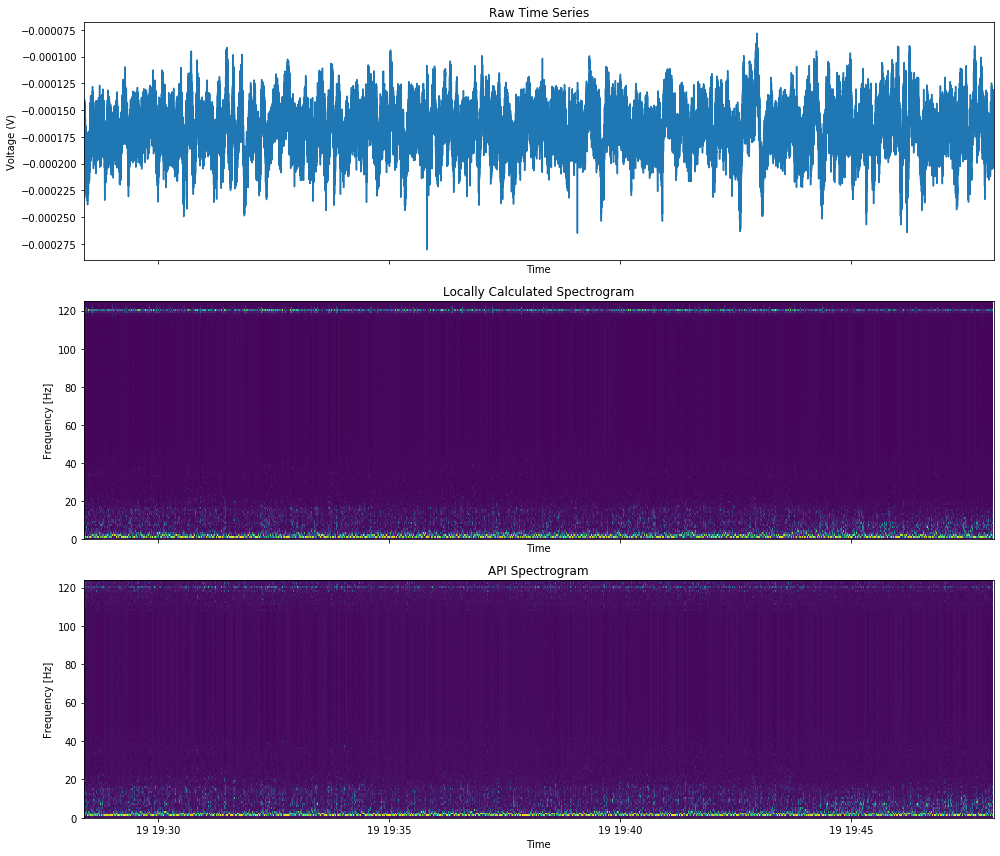

In [11]:
fig, ax = plt.subplots(3,figsize=(14,12), sharex=True)

ax[0].plot(pd.to_datetime(time_series.timestamp, unit='s'), time_series['channel.0'])
ax[0].set(xlabel='Time',ylabel='Voltage (V)')
ax[0].set_title('Raw Time Series')

ax[1].pcolormesh(t_calc, f_calc, Sxx_calc)
ax[1].set(xlabel='Time',ylabel='Frequency [Hz]')
ax[1].set_title('Locally Calculated Spectrogram')

ax[2].pcolormesh(t_api, f_api, Sxx_api)
ax[2].set(xlabel='Time',ylabel='Frequency [Hz]')
ax[2].set_title('API Spectrogram')

plt.tight_layout()

## Summary

Using the Rune API and Python package `runeq`, we obtained raw time series and spectrogram data for a time interval of interest. 